<a href="https://colab.research.google.com/github/YoussefRizkk/Blindy_ImageCaptionGenerator/blob/main/Image_Caption_Generator_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# ** Image Caption Generator
## We will use CNN for image feature extraction and LSTM for NLP.
## We will start by pre-processing steps for both image and text data**

**
## Import Modules and Libraries:**

In [ ]:
from google.colab import drive 
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
import os # os is for handling the files
import pickle # pickle is for storing numpy features, we will use it to store the extracted image feature in it
import numpy as np 
import cv2
from tqdm.notebook import tqdm # it is used to show how much data is proceessed till now, helpful for getting estimation for the overall process.

# Tensorflow and keras modules: 
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input  # This is for extracing features from the image data. 
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer # For text Preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences # pad sequence will even out the whole text representation of features, example a sentence with 10 words and other with 6 words so we have to fill out with zeros
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model # this will give a clear representation of the whole model in terms of an image, so it will be easy to see the archietecture of a model
from tensorflow.keras.layers import Input, Dense, LSTM,Embedding, Dropout, add

In [ ]:
cwd = os.getcwd()

In [ ]:
cwd

'/content'

## **Extract Image Features**

In [ ]:
# Load vgg16 model: 
model = VGG16()
# restructure the model:
model=Model(inputs=model.inputs,outputs=model.layers[-2].output)
# summarize
print(model.summary())

553476096/553467096 [==============================] - 14s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
# Use the model to extract features from images: 
features={}  #Key is the image ID, and the value is the features.
directory = os.path.join(cwd,'/content/drive/MyDrive/My Data Files /Images')

for img_name in tqdm(os.listdir(directory)):
    # Load the image form files 
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224,224))
    # convert image pixels to numpy array:
    image = img_to_array(image)
    #reshape data for model
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2])) #rgb IMAGE , that is why we are having three dimensions.
    # preprocess image for vgg
    image= preprocess_input(image)
    #Extract features:
    feature= model.predict(image,verbose=0)
    #get image ID:
    image_id = img_name.split('.')[0]
    #Store Feature
    features[image_id]=feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
# Store features in a file so that I don't have to extract them every time I run my code: 
# Store features  in pickle: 
pickle.dump(features,open(os.path.join(directory,'features.pkl'),'wb'))  # wb = write binary: we are writing the data into a file
# This will dump oir dictionaty into the pickle and we can reload it again 

In [ ]:
with open(os.path.join('/content/drive/MyDrive/My Data Files /','features.pkl'),'rb') as f:  #rb =read binary: we are reading the data from the file
    features= pickle.load(f) 

**Load the Captions Data**

In [ ]:
with open(os.path.join('/content/drive/MyDrive/My Data Files /','Caption.txt'),'r') as f:
    next(f)
    captions_doc = f.read()  #It will read the whole data

In [ ]:
# To have the corresponding caption for each image: 
# Create mapping of image to captions:
mapping={}
# Process lines:
for line in tqdm(captions_doc.split('\n')):   # Separating each line alone 
    # Split the line by comma (,)
    tokens = line.split(',')   # So tokens of zero will be the image id and tokens of 1 will be the caption.
    if len(line)<2:
        continue       # some lines might contain errors , only single letter , to avoid that we can use this statement, continue means to skip
    image_id,caption = tokens[0], tokens[1:]
    # Remove extension from image ID: 
    image_id = image_id.split('.')[0]
    # Convert Caption list to string
    caption=" ".join(caption)
    # Image can have multiple captions , so store all captions of each image in a list: Create list if needed:
    if image_id not in mapping:
        mapping[image_id] = []
    # Store the caption:
    mapping[image_id].append(caption)  

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

## **Pre-process text data**

In [ ]:
# Pre-processing Captions: 
def clean(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)): 
            # Take one caption at a time
            caption=captions[i]
            # Pre-processing steps: 
            caption=caption.lower()  
            caption=caption.replace('[^A-Za-z]','') # We are only keeping letters, and removing all digits and special characters
            caption=caption.replace('\s+',' ')  # Replace multiple spaces with one space
            #caption= '<start> ' +caption + ' <end>' # Adding starting and ending tags, it will help our model when to start and when to end the prediction, if he reach the end tag it will stop
            # We also want to remove uncessary or meaningless words, examlpe: A girl is eating icecream , I can remove the A, so instead of caption in the previous step I do this classification:
            caption= '<start> ' + " ".join([word for word in caption.split() if len(word)>1]) + ' <end>'
            # Now after pre-processing I want to replace the caption to the corresponding index:
            captions[i]= caption

In [ ]:
# Before text Preprocess: 
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# After text Preprocess:
clean(mapping)

In [ ]:
mapping['1000268201_693b08cb0e']

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [ ]:
### Continue Pre-processing; Tokenization of texts: 
# First have all the captions in one list:
all_captions =[]
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions) 

40455

In [ ]:
all_captions[:10]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>',
 '<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and tri-colored dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>']

In [ ]:
# Tokenize: 
tokenizer= Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size= len(tokenizer.word_index)+1

In [ ]:
vocab_size

8483

In [ ]:
all_captions[:10]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>',
 '<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and tri-colored dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>']

In [ ]:
# max length of the caption:
max_length = max(len(caption.split()) for caption in all_captions)
max_length   # This variable will be used for padding sequence and while model creation.
# As we said before, padding is filling the empty values. 

35

## **Train Test Split**

In [ ]:
# Note: To process the images, turn On GPU and you should have a high capacity of ram.
# If we run without splitting the data, the session will be crashed so we will create a separate function 
# For taking inputs one by one. 
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.85)  # 3mlna split number le hwwi l7d le 90% mn l data 
train= image_ids[:split]   # Train: kl she l7d ma nosl lal split le r2ma 7000 w she le hyyi 90% mn ldata
test=image_ids[split:]   # Test: mn split till the end

## **Data Generator Creation**

In [ ]:
#### Many images, for each image we have image features and several captions.
#### We will create a data generator to fix the image and caption in batch size:
#### The batch size defines the number of samples that will be propagated through the network.
#### For instance, let's say you have 1050 training samples and you want to set up a batch_size equal to 100. 
#### The algorithm takes the first 100 samples (from 1st to 100th) from the training dataset and trains the network. 
#### Next, it takes the second 100 samples (from 101st to 200th) and trains the network again. 
#### Wecan keep doing this procedure until we have propagated all samples through of the network. Problem might happen with the last set of samples. In our example, we've used 1050 which is not divisible by 100 without remainder. The simplest solution is just to get the final 50 samples and train the network.
#### Advantages of using a batch size < number of all samples:
#### It requires less memory. Since you train the network using fewer samples, the overall training procedure requires less memory. That's especially important if you are not able to fit the whole dataset in your machine's memory.
#### Typically networks train faster with mini-batches. That's because we update the weights after each propagation. In our example we've propagated 11 batches (10 of them had 100 samples and 1 had 50 samples) and after each of them we've updated our network's parameters. If we used all samples during propagation we would make only 1 update for the network's parameter.
#### Disadvantages of using a batch size < number of all samples:
#### The smaller the batch the less accurate the estimate of the gradient will be.

In [ ]:
# We have to do this step if we have RAMs around 16gb, if we have rams more than 30 gb no need to do this:
# Create data generator to get data in batch ( avoids session crash):
def data_generator(data_keys, mapping, features,tokinizer,max_length,vocab_size,batch_size):
    # Loop over images
    X1,X2,y = list(),list(),list()
    n = 0  # To determine wether we reached the batch size or not
    while 1:
        for key in data_keys:
            n+=1
            captions=mapping[key]
            for caption in captions:
                # Encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]  # For each word, we will be assigning the index
                # Split the sequence into x,y pairs:
                for i in range(1, len(seq)):
                    # Split into input and output pairs: 
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode the output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # Store the sequence: 
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n== batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield[X1,X2],y
                X1,X2,y = list(),list(),list()
                n = 0

## **Encoder Model Creation: epochs = 10 VS epochs = 23**

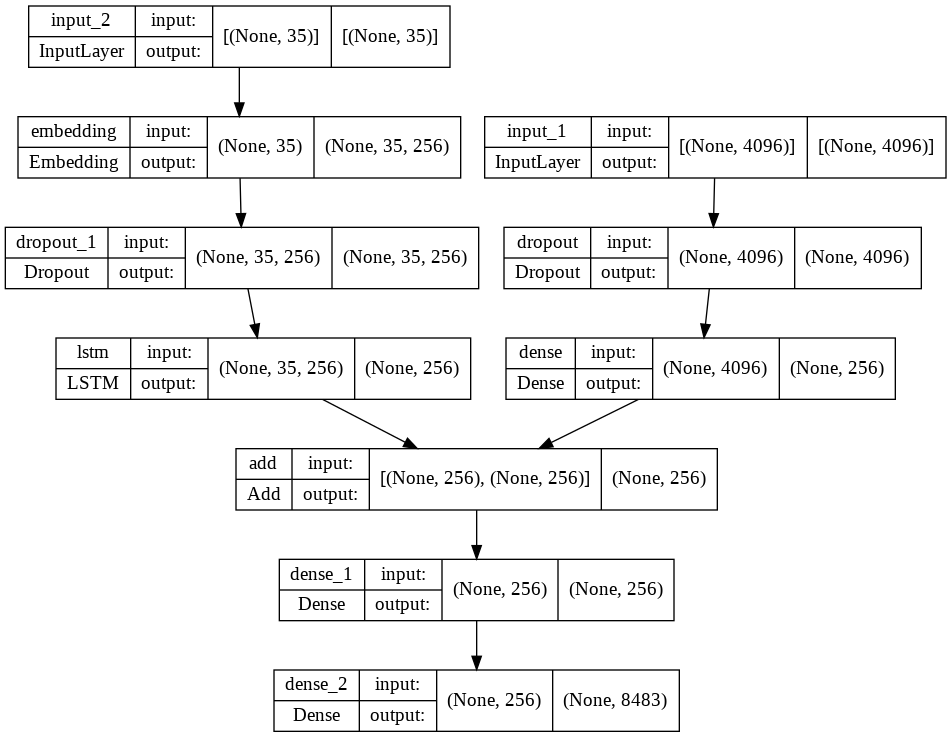

In [ ]:
# Image feature model 
inputs1 = Input(shape=(4096,))   
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256,activation='relu')(fe1)

# Sequence Feature Layers: 
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)
### Decoder Model Creation
decoder1 = add([fe2,se3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)          

model = Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')

# plot the model 
plot_model(model,show_shapes=True)

## We have two inputs and one outputs 
## input layer 6 is for the image , then we have the dropout and dense layer for it
## input layer 7 is for texting, with Embedding , Dropout and LSTM 
## Integrating CNN with LSTM into single dense layer
## 8483 is the categorical one hot encoding

## **Model Training**

In [ ]:
epochs = 10
batch_size= 64
steps = len(train)//batch_size  # After each step it will do the back propagation

for i in range(epochs):
    # Create data generator:
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size,batch_size)
    # fit for one epoch:
    model.fit(generator, epochs=1, steps_per_epoch=steps,verbose=1)

107/107 [==============================] - 39s 367ms/step - loss: 2.7604


In [ ]:
# Function to tranform the output integer of the model to word: 
def idx_to_word(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word 
  return None

In [ ]:
# Generate caption for an image: 
def predict_caption(model , image, tokenizer, max_length):
  # Add start tag for generation     
  in_text = 'start'
  # Iterate over the max length of sequence
  for i in range(max_length):
    #Encode input sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    # pad the sequence
    sequence = pad_sequences([sequence], max_length)
    # Predict next word
    yhat = model.predict([image , sequence], verbose=0)  # This will give the probability of 8000 columns, so we will get the index of highest probability
    # Get index with highest probability
    yhat = np.argmax(yhat)
    # convert index to word
    word = idx_to_word( yhat, tokenizer)
    # stop if word not found: 
    if word is None: 
      break
    # append word as input for generating next word
    in_text += " " + word # predicted word
    # stop of we reach end tag
    if word == 'end':
      break
  return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# Validate with test data : 
actual , predicted = list(), list()

for key in tqdm(test):
  # get actual caption
  captions = mapping[key]
  # predict the caption for image 
  y_pred = predict_caption( model, features[key], tokenizer , max_length)
  # Split into words
  actual_captions = [caption.split() for caption in captions]  # This will generate a list of all the words in the caption , so it will be in an order
  y_pred = y_pred.split()
  # Append to the list
  actual.append(actual_captions)
  predicted.append(y_pred)

# Calculate BLEU Score : We have to consider this score whenever we have to deal with the test data. 
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights =(1.0,0,0,0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights =(0.5,0.5,0,0)))

  0%|          | 0/1214 [00:00<?, ?it/s]

BLEU-1: 0.34100
BLEU-1: 0.28997


## **Encoder Model Creation: epochs = 23 and batch_size = 32**

In [ ]:
epochs = 23
batch_size= 32
steps = len(train)//batch_size  # After each step it will do the back propagation

for i in range(epochs):
    # Create data generator:
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size,batch_size)
    # fit for one epoch:
    model.fit(generator, epochs=1, steps_per_epoch=steps,verbose=1)

214/214 [==============================] - 52s 244ms/step - loss: 2.1136


In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# Validate with test data : 
actual , predicted = list(), list()

for key in tqdm(test):
  # get actual caption
  captions = mapping[key]
  # predict the caption for image 
  y_pred = predict_caption( model, features[key], tokenizer , max_length)
  # Split into words
  actual_captions = [caption.split() for caption in captions]  # This will generate a list of all the words in the caption , so it will be in an order
  y_pred = y_pred.split()
  # Append to the list
  actual.append(actual_captions)
  predicted.append(y_pred)

# Calculate BLEU Score : We have to consider this score whenever we have to deal with the test data. 
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights =(1.0,0,0,0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights =(0.5,0.5,0,0)))

  0%|          | 0/1214 [00:00<?, ?it/s]

BLEU-1: 0.45233
BLEU-1: 0.49855


## **Encoder Model Creation: epochs = 23, batch_size = 64, optimizer = adam**

In [ ]:
epochs = 23
batch_size= 64
steps = len(train)//batch_size  # After each step it will do the back propagation

for i in range(epochs):
    # Create data generator:
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size,batch_size)
    # fit for one epoch:
    model.fit(generator, epochs=1, steps_per_epoch=steps,verbose=1)

107/107 [==============================] - 39s 362ms/step - loss: 2.2091


In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# Validate with test data : 
actual , predicted = list(), list()

for key in tqdm(test):
  # get actual caption
  captions = mapping[key]
  # predict the caption for image 
  y_pred = predict_caption( model, features[key], tokenizer , max_length)
  # Split into words
  actual_captions = [caption.split() for caption in captions]  # This will generate a list of all the words in the caption , so it will be in an order
  y_pred = y_pred.split()
  # Append to the list
  actual.append(actual_captions)
  predicted.append(y_pred)

# Calculate BLEU Score : We have to consider this score whenever we have to deal with the test data. 
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights =(1.0,0,0,0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights =(0.5,0.5,0,0)))

  0%|          | 0/1214 [00:00<?, ?it/s]

BLEU-1: 0.49928
BLEU-1: 0.52633


In [ ]:
# Save the model
model.save('/content/drive/MyDrive/My Data Files /'+'/best_model')

In [ ]:
## Visualize the results
from PIL import Image  # To load the image 
import matplotlib.pyplot as plt
def generate_caption(image_name):
  image_id = image_name.split('.')[0]
  img_path = os.path('/content/drive/MyDrive/My Data Files /Images/', image_name)
  # predict the caption
  y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
  print('------------------Predicted------------------')
  print(y_pred)
  plt.imshow(image)

------------------Predicted------------------
little girl painting rainbow


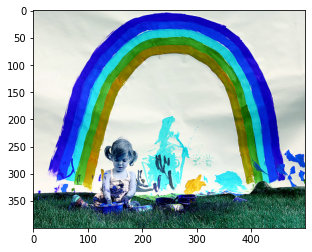

In [ ]:
generate_caption('1002674143_1b742ab4b8.jpg')

------------------Predicted------------------
dogs fighting against each other in physical fight


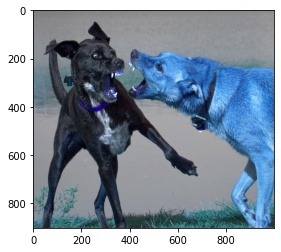

In [ ]:
generate_caption('dog-dog-rough-play.jpg')

## **Encoder Model Creation: epochs = 23, batch_size = 64, optimizer = RMSprop**

In [ ]:
# Image feature model 
inputs1 = Input(shape=(4096,))   
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256,activation='relu')(fe1)

# Sequence Feature Layers: 
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)
### Decoder Model Creation
decoder1 = add([fe2,se3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)          

model = Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='RMSprop')

In [ ]:
epochs = 23
batch_size= 64
steps = len(train)//batch_size  # After each step it will do the back propagation

for i in range(epochs):
    # Create data generator:
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size,batch_size)
    # fit for one epoch:
    model.fit(generator, epochs=1, steps_per_epoch=steps,verbose=1)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# Validate with test data : 
actual , predicted = list(), list()

for key in tqdm(test):
  # get actual caption
  captions = mapping[key]
  # predict the caption for image 
  y_pred = predict_caption( model, features[key], tokenizer , max_length)
  # Split into words
  actual_captions = [caption.split() for caption in captions]  # This will generate a list of all the words in the caption , so it will be in an order
  y_pred = y_pred.split()
  # Append to the list
  actual.append(actual_captions)
  predicted.append(y_pred)

# Calculate BLEU Score : We have to consider this score whenever we have to deal with the test data. 
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights =(1.0,0,0,0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights =(0.5,0.5,0,0)))

In [ ]:
epochs = 23
batch_size= 64
steps = len(train)//batch_size  # After each step it will do the back propagation

for i in range(epochs):
    # Create data generator:
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size,batch_size)
    # fit for one epoch:
    model.fit(generator, epochs=1, steps_per_epoch=steps,verbose=1)

107/107 [==============================] - 37s 347ms/step - loss: 2.2135


In [ ]:
directory = os.path.join(cwd,'/content/drive/MyDrive/My Data Files /')
pickle.dump(model,open(os.path.join(directory,'model.pkl'),'wb')) 

In [ ]:
# Function to tranform the output integer of the model to word: 
def idx_to_word(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word 
  return None

In [ ]:
# Generate caption for an image: 
def predict_caption(model , image, tokenizer, max_length):
  # Add start tag for generation     
  in_text = 'start'
  # Iterate over the max length of sequence
  for i in range(max_length):
    #Encode input sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    # pad the sequence
    sequence = pad_sequences([sequence], max_length)
    # Predict next word
    yhat = model.predict([image , sequence], verbose=0)  # This will give the probability of 8000 columns, so we will get the index of highest probability
    # Get index with highest probability
    yhat = np.argmax(yhat)
    # convert index to word
    word = idx_to_word( yhat, tokenizer)
    # stop if word not found: 
    if word is None: 
      break
    # append word as input for generating next word
    in_text += " " + word # predicted word
    # stop of we reach end tag
    if word == 'end':
      break
  return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# Validate with test data : 
actual , predicted = list(), list()

for key in tqdm(test):
  # get actual caption
  captions = mapping[key]
  # predict the caption for image 
  y_pred = predict_caption( model, features[key], tokenizer , max_length)
  # Split into words
  actual_captions = [caption.split() for caption in captions]  # This will generate a list of all the words in the caption , so it will be in an order
  y_pred = y_pred.split()
  # Append to the list
  actual.append(actual_captions)
  predicted.append(y_pred)

# Calculate BLEU Score : We have to consider this score whenever we have to deal with the test data. 
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights =(1.0,0,0,0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights =(0.5,0.5,0,0)))

  0%|          | 0/1214 [00:00<?, ?it/s]

BLEU-1: 0.359190
BLEU-2: 0.208434


In [ ]:
# Save the model
model.save('/content/drive/MyDrive/My Data Files /'+'/best_model_all')